In [ ]:
!pip install torch torchvision torchaudio
!pip install torch_geometric

In [ ]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='./data/Cora', name="Cora", split="random" ,num_val=270, num_test=270, num_train_per_class=350)

data = dataset[0]

print(f"Train nodes: {data.train_mask.sum().item()}, Val nodes: {data.val_mask.sum().item()}, Test nodes: {data.test_mask.sum().item()}")


Train nodes: 2095, Val nodes: 270, Test nodes: 270


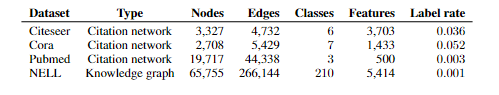

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
class ProjectionMLP(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(ProjectionMLP, self).__init__()
        self.fc1 = torch.nn.Linear(in_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
import random

def node_dropping(data, drop_prob=0.2):
    num_nodes = data.num_nodes
    mask = torch.rand(num_nodes) > drop_prob
    mask_idx = torch.where(mask)[0]

    data.x = data.x[mask_idx]

    mapping = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(mask_idx)}
    new_edge_index = []
    for i in range(data.edge_index.shape[1]):
        u, v = data.edge_index[:, i]
        if u.item() in mapping and v.item() in mapping:
            new_edge_index.append([mapping[u.item()], mapping[v.item()]])

    data.edge_index = torch.tensor(new_edge_index, dtype=torch.long).T
    return data

def edge_perturbation(data, perturb_prob=0.2):
    num_edges = data.edge_index.shape[1]
    num_remove = int(perturb_prob * num_edges)

    mask = torch.rand(num_edges) > perturb_prob
    data.edge_index = data.edge_index[:, mask]

    num_add = num_remove
    new_edges = torch.randint(0, data.num_nodes, (2, num_add))
    data.edge_index = torch.cat([data.edge_index, new_edges], dim=1)

    return data


In [ ]:
def info_nce_loss(z1, z2, tau=0.5):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    similarity_matrix = torch.mm(z1, z2.T) / tau
    labels = torch.arange(z1.shape[0]).to(z1.device)

    loss = F.cross_entropy(similarity_matrix, labels)
    return loss


In [ ]:
def train_graphcl(data, gcn, projection, optimizer, epochs=100):
    gcn.train()
    projection.train()

    for epoch in range(epochs):
        optimizer.zero_grad()

        data_aug1 = node_dropping(data.clone(), drop_prob=0.2)
        data_aug2 = edge_perturbation(data.clone(), perturb_prob=0.2)

        h1 = gcn(data_aug1.x, data_aug1.edge_index)
        h2 = gcn(data_aug2.x, data_aug2.edge_index)

        z1 = projection(h1)
        z2 = projection(h2)

        loss = info_nce_loss(z1, z2)

        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


In [ ]:
gcn = GCN(in_channels=dataset.num_features, hidden_channels=128, out_channels=128)
projection_head = ProjectionMLP(in_dim=128, hidden_dim=128, out_dim=64)

optimizer = torch.optim.Adam(list(gcn.parameters()) + list(projection_head.parameters()), lr=0.01)

train_graphcl(data, gcn, projection_head, optimizer, epochs=100)


Epoch 0, Loss: 7.9037
Epoch 10, Loss: 7.8990
Epoch 20, Loss: 7.8954
Epoch 30, Loss: 7.8890
Epoch 40, Loss: 7.8696
Epoch 50, Loss: 7.8556
Epoch 60, Loss: 7.8230
Epoch 70, Loss: 7.7982
Epoch 80, Loss: 7.7709
Epoch 90, Loss: 7.7582


In [ ]:
import torch
import torch.nn.functional as F

class ClassifierMLP(torch.nn.Module):
    def __init__(self, in_dim, num_classes):
        super(ClassifierMLP, self).__init__()
        self.fc = torch.nn.Linear(in_dim, num_classes)

    def forward(self, x):
        return self.fc(x)


In [ ]:
def fine_tune(data, gcn, classifier, optimizer, epochs=100):
    gcn.eval()
    classifier.train()

    for epoch in range(epochs):
        optimizer.zero_grad()

        with torch.no_grad():
            h = gcn(data.x, data.edge_index)

        logits = classifier(h)

        loss = F.cross_entropy(logits[data.train_mask], data.y[data.train_mask])

        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


In [ ]:
def evaluate(data, gcn, classifier):
    gcn.eval()
    classifier.eval()

    with torch.no_grad():
        h = gcn(data.x, data.edge_index)
        logits = classifier(h)

    pred = logits.argmax(dim=1)
    acc_train = (pred[data.train_mask] == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
    acc_val = (pred[data.val_mask] == data.y[data.val_mask]).sum().item() / data.val_mask.sum().item()
    acc_test = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()

    print(f"Train Acc: {acc_train:.4f}, Val Acc: {acc_val:.4f}, Test Acc: {acc_test:.4f}")


In [ ]:
from torch_geometric.datasets import Planetoid

classifier = ClassifierMLP(in_dim=128, num_classes=dataset.num_classes)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.01)
fine_tune(data, gcn, classifier, optimizer, epochs=100)

evaluate(data, gcn, classifier)


Epoch 0, Loss: 1.9608
Epoch 10, Loss: 1.6203
Epoch 20, Loss: 1.4275
Epoch 30, Loss: 1.2863
Epoch 40, Loss: 1.1825
Epoch 50, Loss: 1.1036
Epoch 60, Loss: 1.0417
Epoch 70, Loss: 0.9919
Epoch 80, Loss: 0.9507
Epoch 90, Loss: 0.9159
Train Acc: 0.7437, Val Acc: 0.6519, Test Acc: 0.6593


In [ ]:
# from torch_geometric.datasets import TUDataset

# dataset_name = "NCI1"
# dataset = TUDataset(root='./data', name=dataset_name)


Processing...
Done!


In [ ]:
# from torch_geometric.nn import global_mean_pool

# def fine_tune(data, gcn, classifier, optimizer, epochs=100):
#     gcn.eval()
#     classifier.train()

#     for epoch in range(epochs):
#         optimizer.zero_grad()

#         with torch.no_grad():
#             h = gcn(data.x, data.edge_index)
#             h = global_mean_pool(h, data.batch)

#         logits = classifier(h)
#         loss = F.cross_entropy(logits, data.y)

#         loss.backward()
#         optimizer.step()

#         if epoch % 10 == 0:
#             print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


In [ ]:
# from torch_geometric.loader import DataLoader

# batch_size = 32
# train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
# def train_graphcl(loader, gcn, projection, optimizer, epochs=100):
#     gcn.train()
#     projection.train()

#     for epoch in range(epochs):
#         for data in loader:
#             optimizer.zero_grad()

#             data_aug1 = node_dropping(data.clone(), drop_prob=0.2)
#             data_aug2 = edge_perturbation(data.clone(), perturb_prob=0.2)

#             h1 = gcn(data_aug1.x, data_aug1.edge_index)
#             h2 = gcn(data_aug2.x, data_aug2.edge_index)

#             h1 = global_mean_pool(h1, data.batch)
#             h2 = global_mean_pool(h2, data.batch)

#             z1 = projection(h1)
#             z2 = projection(h2)

#             loss = info_nce_loss(z1, z2)

#             loss.backward()
#             optimizer.step()

#         if epoch % 10 == 0:
#             print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


In [ ]:
# class GraphClassifierMLP(torch.nn.Module):
#     def __init__(self, in_dim, hidden_dim, num_classes):
#         super(GraphClassifierMLP, self).__init__()
#         self.fc1 = torch.nn.Linear(in_dim, hidden_dim)
#         self.fc2 = torch.nn.Linear(hidden_dim, num_classes)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x


In [ ]:
# def fine_tune(loader, gcn, classifier, optimizer, epochs=100):
#     gcn.eval()
#     classifier.train()

#     for epoch in range(epochs):
#         for data in loader:
#             optimizer.zero_grad()

#             with torch.no_grad():
#                 h = gcn(data.x, data.edge_index)
#                 h = global_mean_pool(h, data.batch)

#             logits = classifier(h)
#             loss = F.cross_entropy(logits, data.y)

#             loss.backward()
#             optimizer.step()

#         if epoch % 10 == 0:
#             print(f"Epoch {epoch}, Loss: {loss.item():.4f}")



In [ ]:
# dataset_name = "NCI1"
# dataset = TUDataset(root='./data', name=dataset_name)

# num_train = int(len(dataset) * 0.8)
# num_val = int(len(dataset) * 0.1)
# num_test = len(dataset) - num_train - num_val

# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [num_train, num_val, num_test])

# batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# gcn = GCN(in_channels=dataset.num_features, hidden_channels=128, out_channels=128)
# projection_head = ProjectionMLP(in_dim=128, hidden_dim=64, out_dim=64)
# classifier = GraphClassifierMLP(in_dim=128, hidden_dim=64, num_classes=dataset.num_classes)

# optimizer_graphcl = torch.optim.Adam(list(gcn.parameters()) + list(projection_head.parameters()), lr=0.01)
# optimizer_finetune = torch.optim.Adam(classifier.parameters(), lr=0.01)

# train_graphcl(train_loader, gcn, projection_head, optimizer_graphcl, epochs=100)

# fine_tune(train_loader, gcn, classifier, optimizer_finetune, epochs=100)

# evaluate(test_loader, gcn, classifier)

RuntimeError: Expected index [999] to be smaller than self [32] apart from dimension 0 and to be smaller size than src [819]